In [1]:
import math
import torch
import gpytorch
import numpy as np
import numpy.linalg as linalg

import spectralgp

from spectralgp.samplers import AlternatingSampler
from spectralgp.models import ExactGPModel, SpectralModel, ProductKernelSpectralModel

from spectralgp.sampling_factories import ss_factory, ess_factory
from custom_plotting import plot_kernel

import data

import utils
import argparse

import sys
import matplotlib.pyplot as plt

import traceback

torch.set_default_dtype(torch.float64)

In [2]:
train_x, train_y, test_x, test_y, y_std, y_std_train, gen_kern = data.read_data('servo', nx=None, gen_pars=None,
                                                            linear_pars=None,
                                                            spacing='random',
                                                            noise=None)
in_dims = 1 if train_x.dim() == 1 else train_x.size(1)

use_cuda = torch.cuda.is_available()
print('Cuda is available', use_cuda)
if use_cuda:
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    train_x, train_y, test_x, test_y, y_std = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda(), y_std.cuda()
    if gen_kern is not None:
        gen_kern = gen_kern.cuda()

###########################################
## set up the spectral and latent models ##
###########################################
print("Input Dimensions {}".format(in_dims))



mlatent = 'shared'
shared = True if mlatent == 'shared' else False

Cuda is available True
Input Dimensions 4


In [3]:
data_lh = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-3))
data_mod = spectralgp.models.ProductKernelSpectralModel(train_x, train_y, data_lh, shared=shared,
        normalize = False, symmetrize = False, num_locs = 100, spacing='random', pretrain=False, omega_max = 8., nonstat = True)

0
tensor(8.)
0
tensor(8.)
0
tensor(8.)


In [4]:
alt_sampler = spectralgp.samplers.AlternatingSampler(
    [data_mod], [data_lh], 
    spectralgp.sampling_factories.ss_factory, [spectralgp.sampling_factories.ess_factory],
    totalSamples=10, numInnerSamples=5, numOuterSamples=5, num_dims=in_dims
    )


alt_sampler.run()

Step:  0 Dimension:  0
Loss is:  tensor(-84.0401, grad_fn=<DivBackward0>)
Loss is:  tensor(-82.8739, grad_fn=<DivBackward0>)
Loss is:  tensor(-81.7301, grad_fn=<DivBackward0>)
Loss is:  tensor(-80.6058, grad_fn=<DivBackward0>)
Loss is:  tensor(-79.4936, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  1
Loss is:  tensor(-78.9950, grad_fn=<DivBackward0>)
Loss is:  tensor(-77.9179, grad_fn=<DivBackward0>)
Loss is:  tensor(-76.8415, grad_fn=<DivBackward0>)
Loss is:  tensor(-75.7917, grad_fn=<DivBackward0>)
Loss is:  tensor(-74.7484, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  2
Loss is:  tensor(-74.2043, grad_fn=<DivBackward0>)
Loss is:  tensor(-73.1716, grad_fn=<DivBackward0>)
Loss is:  tensor(-72.1722, grad_fn=<DivBackward0>)
Loss is:  tensor(-71.1721, grad_fn=<DivBackward0>)
Loss is:  tensor(-70.2033, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  3
Loss is:  tensor(-69.0216, grad_fn=<DivBackward0>)
Loss is:  tensor(-68.0490,

Loss is:  tensor(-13.5956, grad_fn=<DivBackward0>)
Loss is:  tensor(-13.4285, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 6
Step:  6 Dimension:  3
Loss is:  tensor(-13.2034, grad_fn=<DivBackward0>)
Loss is:  tensor(-13.0470, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.8971, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.7442, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.5964, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 6
Seconds for Iteration 6 : 4.347280025482178
Step:  7 Dimension:  0
Loss is:  tensor(-12.3389, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.1899, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.0575, grad_fn=<DivBackward0>)
Loss is:  tensor(-11.9091, grad_fn=<DivBackward0>)
Loss is:  tensor(-11.7865, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 7
Step:  7 Dimension:  1
Loss is:  tensor(-11.4347, grad_fn=<DivBackward0>)
Loss is:  tensor(-11.3075, grad_fn=<DivBackward0>)
Loss is:  tensor(-11.1724, grad_fn=<DivBackward0>)
Loss is:  tensor(-11.0300, grad_fn=<DivBackward0>)
Loss 

/home/jayson_s/anaconda3/envs/spectralgp/lib/python3.7/site-packages/matplotlib-3.0.3-py3.7-linux-x86_64.egg/matplotlib/axes/_base.py:380: MatplotlibDeprecationWarning: 
cycling among columns of inputs with non-matching shapes is deprecated.
  cbook.warn_deprecated("2.2", "cycling among columns of inputs "


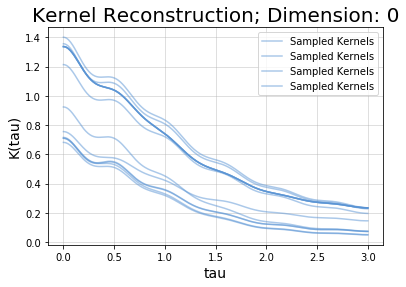

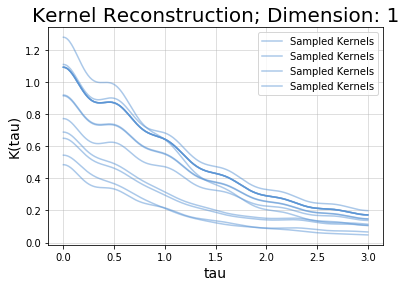

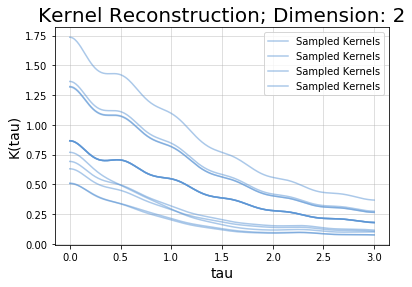

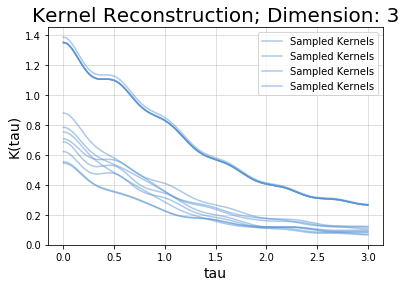

In [5]:
plot_kernel(alt_sampler, data_mod, None)